<a href="https://colab.research.google.com/github/zmanaa/COE595/blob/main/COE595__Assg_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COE 595 (Advanced Computer Vision Processing):

##  ASSIGNMENT 1


**Description:**

  In this hands-on assignment, you will apply the concepts of feature detection, description and matching methods using OpenCV2 library, and re-assemble an image's slices to match the original image's snapshot

**Deliverables**

  * Completed version of this notebook, renamed to `COE595-Assg1-<Student1_ID>-<Student2_ID>.ipynb`
  * A short report following the below outline:
    * Problem Statement
    * Solution Design and Methodology
      * Describe your proposed solution using a flowchart and psuedocode
    * Experiments and Results
      * Try your solution on some sample images, and include the snapshots of intermediate results, the final re-assembled image, and similarity scores
      * Refer to the hands-on tutorial to see how to implement matching and to show matching results
    * Team details: Names and IDs of the team
  * The original images you used in your work
  

**Submission Instructions:**

Please submit all the deliverables on Blackboard (as individual files and not as a zip/rar archive)


**Credits:**

Prepared by Dr. Abdul Jabbar Siddiqui


In [ ]:
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity


In [ ]:
# to mount your google drive (requires Google log in)
# Alternatively, use the "Mount Drive" button from the "Files" tab on the left menu bars
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Copy and save path to your images directory in mypath
mypath = '/content/drive/MyDrive/COE 595 Course Files/Assignments/Assignment 1'

# Load Images

In [ ]:
# Read the larger scene image in which you want to find the query_img object in scene_img
scene_img = cv2.imread(mypath+'/test_img.jpeg')

# Slice and Shuffle Scene Image

In [ ]:
# DO NOT CHANGE THIS CELL

# Convert images to grayscale (recommended for ease of using opencv feature descriptors like SIFT, ORB, SURF, etc.)

scene_img_bw = cv2.cvtColor(scene_img, cv2.COLOR_BGR2GRAY)


# Function to take a scene_img and split it into multiple slices, returns a shuffled list of slices
def slice_and_shuffle(inimg, doShuffle=True):
  M = inimg.shape[0] // 5
  N = inimg.shape[1] // 5
  # M=5, N=5, to make 25 tiles from a given inimg

  tiles = [inimg[x:x+M,y:y+N] for x in range(0,inimg.shape[0],M) for y in range(0,inimg.shape[1],N)]

  if doShuffle:
    random.shuffle(tiles)

  return tiles

slices_list = slice_and_shuffle(scene_img_bw)

# Tasks to do:
  * Complete the function `reassemble_slices(...)`: using feature detection and matching, re-assemble the slices in `slices_list` to produce the `reassembled_img`
    
    * Hint: select an appropriate feature detector/descriptor and use feature matching to match each slice with the respective region in `scene_img_bw`
    * Note:
      * your solution must not be based on prior knowledge of the slicing sequence or shuffling order. The re-assembling should be based on matching
      * Your solution must have a verification step to deal with "confused" matches and correct those
      * Your solution must not be specific to one image, it should be generic enough to work with different images



In [ ]:
def assign_index(row, col):
    return int(row * 5 + col)


def find_index(x, y, in_img):
  # A function that return an index between 0 to 24 to represent the tile location

  # Get the average of them to represent the tile with one value
  avg_x_pos = np.mean(x)
  avg_y_pos = np.mean(y)

  # Map the value to have an index between 0 and 4
  col = np.floor((avg_x_pos/in_img.shape[1])*5)
  row = np.floor((avg_y_pos/in_img.shape[0])*5)

  # Map to give a value for the index between 0 and 24
  indx = assign_index(row, col)

  return indx

In [ ]:
slices_list__ = slice_and_shuffle(scene_img_bw, doShuffle=False)

In [ ]:
MIN_MATCH_COUNT = 4
NUM_OF_TILES = 25
copy_of_scene_img_bw = scene_img_bw

# Initiate SIFT detector
sift = cv2.SIFT_create()

train_img = copy_of_scene_img_bw         # trainImage
kp_train, des_train = sift.detectAndCompute(train_img, None)

# Create an empty dict to store matched tiles
matched_tile = {}

for indx in range(0, NUM_OF_TILES, 1):
  query_img = slices_list[indx]          # queryImage

  # Find the keypoints and descriptors with SIFT
  kp_query, des_query = sift.detectAndCompute(query_img, None)

  FLANN_INDEX_KDTREE = 1
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 3)
  search_params = dict(checks = 50)

  flann = cv2.FlannBasedMatcher(index_params, search_params)
  matches = flann.knnMatch(des_query, des_train, k=2)


  # Store all the good matches as per Lowe's ratio test.
  good = []
  for mat, (m,n) in enumerate(matches):
      if m.distance < 0.7*n.distance:
          good.append(m)


  if len(good) > MIN_MATCH_COUNT:
      # For masking
      src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
      dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

      # For point extraction
      src_pts__ = np.float32([ kp_query[m.queryIdx].pt for m in good ])
      dst_pts__ = np.float32([ kp_train[m.trainIdx].pt for m in good ])

      query_x, query_y = zip(*src_pts__)
      train_x, train_y = zip(*dst_pts__)

      M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

      matches_mask = mask.ravel().tolist()

      h, w = train_img.shape
      pts = np.float32([ [0,0], [0,h-1], [w-1,h-1], [w-1,0] ]).reshape(-1,1,2)
      dst = cv2.perspectiveTransform(pts,M)

      tile_match_indx = find_index(train_x, train_y, train_img)
      matched_tile[indx] = {"tile No.": indx,
                            "tile indx": tile_match_indx,
                            'tile': query_img}

      sift_match_flag = True
  else:
      matches_mask = None
      sift_match_flag = False
      scores = []  # Initialize scores as an empty list

      for i in range(0, NUM_OF_TILES, 1):

          score = structural_similarity(query_img, slices_list__[i])
          if score == 1:
            max_score_value = score
            max_score_index = i


      matched_tile[indx] = {"tile No.": indx,
                            "tile indx": max_score_index,
                            'tile': query_img}

In [ ]:
def reassemble_slices(sdict = matched_tile, orig_img = scene_img_bw):

  # Create a blank canvas
  plain_canvas = np.zeros_like(copy_of_scene_img_bw)

  # Calculate tile dimensions
  M = copy_of_scene_img_bw.shape[0] // 5
  N = copy_of_scene_img_bw.shape[1] // 5

  # Organize matched tiles with indices
  matched_tile_with_index = {}
  for cn in range(25):
      for tile_number, tile_data in matched_tile.items():
          if tile_data['tile indx'] == cn:
              matched_tile_with_index[cn] = {"tile data": tile_data}

  # Fill the plain canvas with matched tiles
  for count in range(25):
      row, col = divmod(count, 5)
      tile_data = matched_tile_with_index[count]['tile data']['tile']
      plain_canvas[row * M : (row + 1) * M, col * N : (col + 1) * N] = tile_data

  reassembled_img = plain_canvas

  return reassembled_img


reassembled_img = reassemble_slices(matched_tile, scene_img_bw)

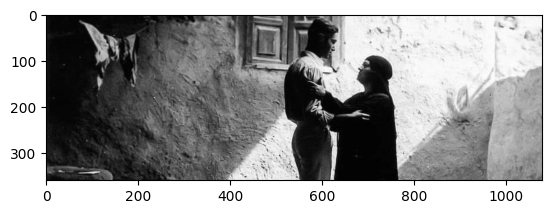

In [ ]:
plt.imshow(reassembled_img, 'gray')
plt.show()

# Testing

  * Compare your `reassembled_img` with `scene_img_bw`
  * Use scikit-image library's Structural Similarity Index (SSIM) to compare
    * Read https://scikit-image.org/docs/stable/api/skimage.metrics#skimage.metrics.structural_similarity for more info

In [ ]:
# This function compares scene_img_bw and reassembled_img to check for correctness in re-assembling

from skimage.metrics import structural_similarity

def check_reassembly(prod=reassembled_img, orig=scene_img_bw):
  score = structural_similarity(reassembled_img, scene_img_bw)

  return score

In [ ]:
# You may test your reassembled_img's similarity to the original scene_img_bw

print(check_reassembly(reassembled_img, scene_img_bw))


1.0
